In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 16.0 MB/s eta 0:00:00


In [ ]:
from torchvision import datasets
from torchvision import transforms
import torch
from torchmetrics import Accuracy

device = "cuda" if torch.cuda.is_available() else "cpu"

transform_train = transforms.Compose([transforms.RandomCrop(28, padding=4), transforms.RandomHorizontalFlip(p=0.5), # optional for fashion items
                                      transforms.ToTensor(), transforms.Normalize((0.2860405969887955,), (0.35302424451492237,)) ])

transform_test = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.2860405969887955,), (0.35302424451492237,)) ])



training_data = datasets.FashionMNIST(
    root='data',
    train = True,
    download=True,
    transform=transform_train
)

testing_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transform_test
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 306kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.61MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.9MB/s]


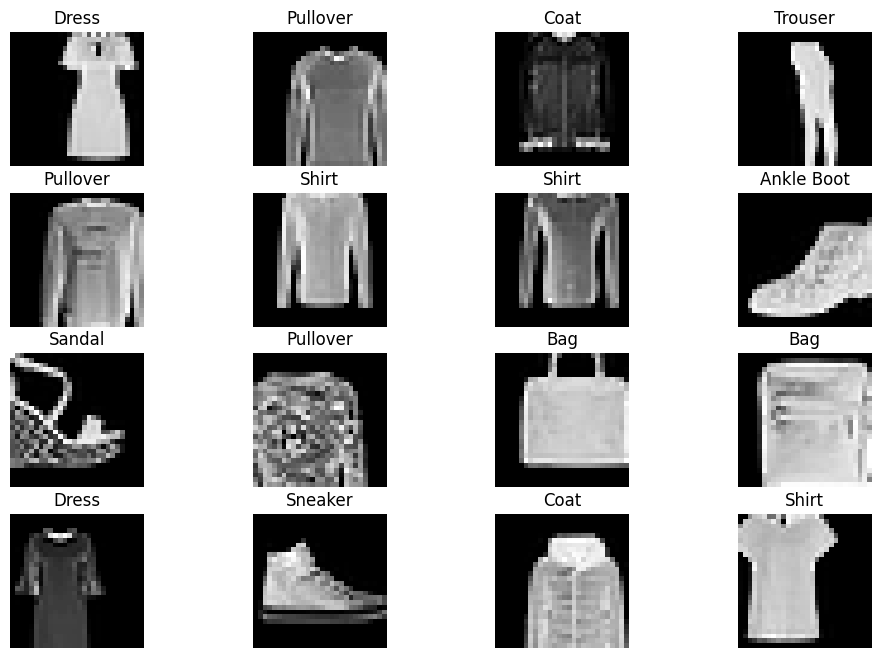

number of data in training: 60000
number of data in testing: 10000


In [ ]:
import matplotlib.pyplot as plt
import torch

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(12,8))
cols, rows = 4,4
for i in range(1, cols*rows+1):
  rand_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[rand_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()

print(f"number of data in training: {len(training_data)}")
print(f"number of data in testing: {len(testing_data)}")


Image shape: torch.Size([1, 28, 28])


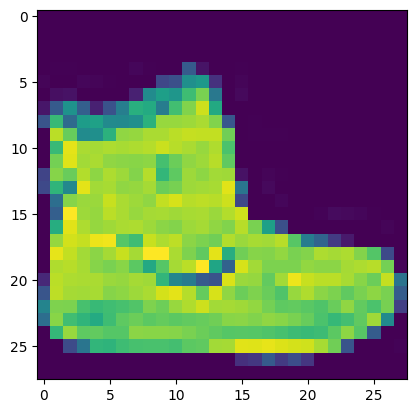

In [ ]:
#print(training_data[0])
img, label = training_data[0]
plt.imshow(img.squeeze())
print(f"Image shape: {img.shape}")


In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 64
training_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=False)
print(f"training data number of batches of {BATCH_SIZE}: {len(training_dataloader)}")
print(f"testing data number of batches of {BATCH_SIZE}: {len(testing_dataloader)}")



training data number of batches of 64: 938
testing data number of batches of 64: 157


In [ ]:
import torch
from torch import nn


import torch.nn as nn

class ResidualBlock(nn.Module):
    """A basic residual block with two convolutional layers"""
    def __init__(self,
          in_channels,
                        out_channels,
                        stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,
                                out_channels,
                                kernel_size=3,
                                stride=stride,
                                padding=1,
                                bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,
                                out_channels,
                                kernel_size=3,
                                stride=1,
                                padding=1,
                                bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Skip connection adjustment if dimensions change
        self.skip_connection = nn.Sequential()
        # f stride != 1: The spatial dimensions (height/width) change
        #If in_channels != out_channels: The depth (number of channels) changes
        if stride != 1 or in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels,
                          out_channels,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        identity = self.skip_connection(identity)
        out += identity
        return self.relu(out)


In [ ]:
import torch
from torch import nn

class ResNetRGB(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, # gray scale image is 1, while RGB is 3
                      32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.block1 = self._make_layer(32, 32, num_blocks=2, stride=1)
        self.block2 = self._make_layer(32, 64, num_blocks=2, stride=2)
        self.block3 = self._make_layer(64, 128, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

# Instantiate model
model = ResNetRGB().to(device)

#model(torch.randn(32, 1, 28, 28).to(device))


Using cuda


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)


In [ ]:
EPOCHS = 10
total_epoch_count = []

accuracy_mc = Accuracy(task="multiclass", num_classes=10).to(device)

total_training_loss, total_testing_loss = [], []
total_train_acc, total_test_acc = [], []
epoch_count = []

for epoch in range(EPOCHS):

    model.train()
    train_loss, train_acc = 0, 0
    accuracy_mc.reset()

    for X, y in training_dataloader:
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = logits.argmax(1)

        train_loss += loss.item()
        train_acc += accuracy_mc(y_pred, y)

    avg_train_loss = train_loss / len(training_dataloader)
    avg_train_acc = train_acc / len(training_dataloader)

    # ---- Testing ----
    model.eval()
    test_loss, test_acc = 0, 0
    accuracy_mc.reset()

    with torch.no_grad():
        for X, y in testing_dataloader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = loss_fn(logits, y)
            y_pred = logits.argmax(1)

            test_loss += loss.item()
            test_acc += accuracy_mc(y_pred, y)

    avg_test_loss = test_loss / len(testing_dataloader)
    avg_test_acc  = test_acc / len(testing_dataloader)

    total_training_loss.append(avg_train_loss)
    total_testing_loss.append(avg_test_loss)
    total_train_acc.append(avg_train_acc.item())
    total_test_acc.append(avg_test_acc.item())
    epoch_count.append(epoch)

    print(f"Epoch {epoch}: "
          f"train_loss={avg_train_loss:.3f} "
          f"train_acc={avg_train_acc:.3f} "
          f"test_loss={avg_test_loss:.3f} "
          f"test_acc={avg_test_acc:.3f}")


Epoch 0: train_loss=0.789 train_acc=0.726 test_loss=0.672 test_acc=0.744
Epoch 1: train_loss=0.457 train_acc=0.832 test_loss=0.492 test_acc=0.823
Epoch 2: train_loss=0.376 train_acc=0.862 test_loss=0.387 test_acc=0.861
Epoch 3: train_loss=0.335 train_acc=0.878 test_loss=0.317 test_acc=0.885
Epoch 4: train_loss=0.306 train_acc=0.890 test_loss=0.336 test_acc=0.877
Epoch 5: train_loss=0.286 train_acc=0.897 test_loss=0.289 test_acc=0.897
Epoch 6: train_loss=0.272 train_acc=0.902 test_loss=0.284 test_acc=0.899
Epoch 7: train_loss=0.260 train_acc=0.906 test_loss=0.268 test_acc=0.901
Epoch 8: train_loss=0.251 train_acc=0.910 test_loss=0.256 test_acc=0.909
Epoch 9: train_loss=0.242 train_acc=0.912 test_loss=0.263 test_acc=0.906


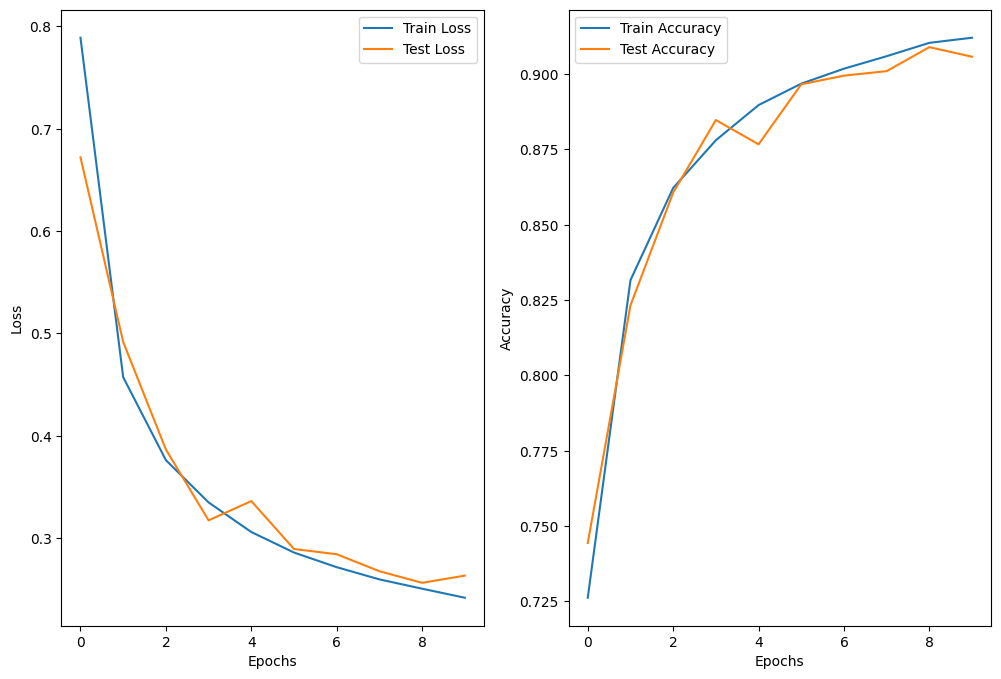

In [ ]:
figure = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(epoch_count, total_training_loss, label='Train Loss')
plt.plot(epoch_count, total_testing_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_count, total_train_acc, label='Train Accuracy')
plt.plot(epoch_count, total_test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()